STA 220 Homework 2
===========

- Do not distribute
- Do the entire homework here in the notebook by adding cells below the given exercise.
- When turning the homework in simply submit your notebook file to canvas.
- Obviously, do not copy the code from some online source or the other students.
- After finishing the homwork, please select Kernel -> Restart & Run All, then save, submit

## Your Name: Chenghan Sun

## Your Student ID: 915030521

The multi-armed bandit framework assumes that you are in a two player game where you select a number from 1 to K (we call this number the arm that you pulled).  Then the other player selects a reward, $r_{i,t}$ based on the arm, $i$, at time $t$ that you selected and reveals that to you.  Your job is to come up with a policy which determines which arm to pull at a given time based on the past performances of the arms.

The name multi-armed bandit comes from the gambling world, in which a slot machine is called a one armed bandit.  In that setting, you pull the arm and recieve some reward.  In this fictional setting there are multiple arms for the slot machine, each paying out different rewards.  Because you can only pull one at a time, you only see the reward from the arm you pulled.  This partial observability puts you in the challenging position of needing to explore the arms, seeing which has better performance, before you start to exploit the best arm.  Below is a simulation from a simple mult-armed bandit.

In [31]:
import numpy as np
import time
from matplotlib import pyplot as plt
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
plt.style.use('ggplot')

In [2]:
class SimpleBandit:
    '''
    The bandit class you will use in this homework. DO NOT modify
    '''
    def __init__(self):
        self._mu = np.array([-1.,-2.,1.5,0.5,-0.25,.75,.1,1.8,-3])
        self._p = 1 / (1 + np.exp(-self._mu))
        self.num_arms = len(self._mu)
        self.total_rewards = np.zeros(len(self._mu))
        
    def pull(self,arms):
        self.current_rewards = np.random.binomial(1,self._p)
        self.total_rewards += self.current_rewards
        return self.current_rewards[arms]

In [ ]:
np.random.seed(5)
band = SimpleBandit()  # reset
[band.pull(2) for t in range(10)]  # do arm 1 for 10 times 
# band.pull(2)  # set one arm and only pull once 

In the above we see that if we had pulled the 1 arm 10 times then our total reward for that arm is 2 because it returned a 1 twice.  Our rewards are binary, only 0 or 1.  You can also see the total rewards from each arm below.

In [ ]:
band.total_rewards  # for each arm 

In [ ]:
print(band.current_rewards)  # current rewards list for each arm 
print(band.total_rewards)  # total rewards for each arm w.r.t 10(above) time steps

One simple policy is to always pull the arm 2, and another is to pull the arm 1.  We can compare these with the following:

In [ ]:
rewards = np.array([band.pull([1,2]) for t in range(100)])

rewards now has the rewards for each policy in each column, we can compare the rewards for these policies below.

In [ ]:
rewards.sum(axis=0)  # first two arms, 100 time steps 

It seems that 'always pull 2' is a better policy.  Another simple policy is to randomly select an arm and pull it.  This can be seen as a pure exploration policy.  All of your policies should have the select_arm method which tells you which arm to pull, and the update_reward method which updates any internal state information based on the observed reward.  In this case nothing needs to be updated.

In [3]:
class RandomPolicy:
    """
    Random policy, pure exploration. DO NOT modify
    """
    def __init__(self, num_arms):
        self.num_arms = num_arms
        self.current_arm = None
        
    def select_arm(self):
        """
        choose which arm to pull
        """
        self.current_arm = np.random.randint(self.num_arms)
        return self.current_arm
    
    def update_reward(self, reward):
        """
        enter observed reward
        """
        return None

**Exercise 1.** The regret of a bandit policy is the difference between the total reward you would get from the "best" arm in hindsight and the total reward your policy recieved.  So if your policy selected arms $i_1,\ldots,i_T$ for total of $T$ time, then the regret is 
$$\max_j \sum_{t=1}^T r_{j,t} - \sum_{t=1}^T r_{i_t,t}.$$
The SimpleBandit class maintains what reward you would have recieved if you just pulled a given arm in the ``total_rewards`` attribute (`current_rewards[i]` is the total reward recieved if i is pulled each time).  Fill the def below which takes a list of policies to play over T time steps and returns a list of regrets for each policy.  Test it on the simple bandit and random policy.

In [6]:
def run_trajectory(bandit, policies, T):
    """
    Run T steps of bandit pulling each policy in each time step
    
    Arguments:
    bandit:
        a fresh instance of a Bandit class,
        in this homework you will be always using an instance from RandomPolicy class
    
    policies:
        a list like [policy1, policy2, policy3 ...]
        each of the policy will have select_arm method and update_reward method
    
    Output: 
        regret of each policy in list, like
        [regret1, regret2, ...]
    """
    arms_cumulative_rewards = np.zeros(len(policies))  # initialize the policy space 
    for t in range(T):  # iterate all time steps
        selected_arms = [p.select_arm() for p in policies]  # select random arm T times under each policy
        arms_current_rewards = bandit.pull(selected_arms)  # pull, pass to policy class
        
        global CurRewardList
        if 'Epsilon_Greedy_Policy' in str(policies):
            CurRewardList.append(arms_current_rewards[1])  # for compete in exercise 2
        elif 'UCB' in str(policies):
            CurRewardList.append(arms_current_rewards[1])  # append to global scope
        elif 'Exp3' in str(policies):
            CurRewardList.append(arms_current_rewards[1])  # append to global scope
            
        arms_cumulative_rewards += arms_current_rewards
        regrets = [np.amax(bandit.total_rewards) - cu_reward for cu_reward in arms_cumulative_rewards]
        # print(f"The regret at the {t}th time step for the {len(policies)} arms: \033[91m{regrets}\033[0m")
    return regrets

In [7]:
# test code, do not change
t1 = time.time()
num_arms = SimpleBandit().num_arms
p = RandomPolicy(num_arms)
policies = [p]
regrets = [run_trajectory(SimpleBandit(), policies, 1000) for _ in range(10)]
print('Time Usage : {}'.format(time.time() - t1))
print(regrets)
np.mean(regrets)

Time Usage : 0.47525668144226074
[[339.0], [371.0], [395.0], [378.0], [370.0], [388.0], [341.0], [338.0], [360.0], [357.0]]


363.7

**Exercise 2.** epsilon-greedy is a policy that has a few roughly equivalent variants, but the one we will use is the following:  For each time step, with probability epsilon, pull an arm at random, otherwise pull the current best arm.  The current best arm is the one which has the most **mean** reward up to that time.  If there is a tie for current best policy, break the tie randomly.

Implement epsilon-greedy in the following class, test it by having it compete once with the random policy for epsilon=0.1 for T = 1000 time points.

In [54]:
class Epsilon_Greedy_Policy:
    """ 
    Epsilon-greedy algorithm:
        With probability epsilon, pull an arm at random, otherwise pull the current best arm.
        The current best arm is the one which has the most total reward up to that time
    """
    def __init__(self, num_arms, eps):
        self.num_arms = num_arms  # total number of arms 
        self.current_arm = None
        self.eps = eps  # probability epsilon for decision making 
        self.t = 0  # initialized time step 
        self.arms_counter = np.zeros(self.num_arms)
        self.arms_performance = np.zeros(self.num_arms)  # update arms mean rewards dynamically 
        
    def greedy_mode(self):
        """ Greedily policy: 
                decision made dynamically with updated performance of bandit for each pull 
        """
        self.arms_counter, self.arms_performance = self.update_reward()
        # pure exploit
        greedy_choice = np.argmax(self.arms_performance)  # the arm with the most mean reward
        
        # if there is a tie for current best policy
        # collect all the best arm indices
        ties = [index for index, value in enumerate(self.arms_performance) if value == greedy_choice]
        if len(ties) > 1:
            greedy_choice = np.random.choice(ties)  # break the tie randomly
        return greedy_choice
    
    def select_arm(self):
        """ Choose arms based on Epsilon-greedy:
            Apply:
                Random Policy -- explore -- RandomPolicy()
            or
                greedy policy -- exploit -- self.greedy_mode()
        """
        rand_flag = np.random.rand()
        if rand_flag < self.eps:
            self.arms_counter, self.arms_performance = self.update_reward()  # update reward
            self.current_arm = RandomPolicy(self.num_arms).select_arm()  # apply explore
        elif rand_flag > self.eps:
            self.current_arm = self.greedy_mode()  # apply exploit
        self.t += 1
        return self.current_arm
        
    def update_reward(self):
        """ 
        Update: 
            1. arm space
            2. arm mean performance 
        """
        if self.current_arm == None:
            return self.arms_counter, self.arms_performance
        
        global CurRewardList
        current_reward = CurRewardList[self.t-1]  # receive current reward from global scope 
        self.arms_counter[self.current_arm] += 1  # update known-arms space
        # update rewards histroy
        self.arms_performance[self.current_arm] += (
            current_reward - self.arms_performance[self.current_arm]) / self.arms_counter[self.current_arm]
        return self.arms_counter, self.arms_performance


In [56]:
# test code 
# Your code here, 
    # generate 10 regrets with simple bandit and epsilon-greedy policy, 
    # save results in regrets,
    # refer to second block in exercise 1
    
np.random.seed(5)
t1 = time.time()
CurRewardList = []
num_arms = SimpleBandit().num_arms
rp = RandomPolicy(num_arms)
eg = Epsilon_Greedy_Policy(num_arms, 0.1)
policies = [rp, eg]
regrets = [run_trajectory(SimpleBandit(), policies, 1000) for _ in range(10)]
print(regrets)
print('Time Usage : {}'.format(time.time() - t1))
np.mean(regrets)

[[335.0, 169.0], [368.0, 34.0], [353.0, 37.0], [392.0, 34.0], [395.0, 37.0], [359.0, 37.0], [378.0, 32.0], [342.0, 44.0], [366.0, 41.0], [375.0, 31.0]]
Time Usage : 0.6817059516906738


207.95

In [57]:
len(CurRewardList)

10000

**Exercise 3.** Exp3 is a policy that is more nuanced.  The idea is that at each time point you pull an arm with some probability `pi[i]` which is updated based on the performance of the arm.  Look at the full algorithm in http://proceedings.mlr.press/v24/seldin12a/seldin12a.pdf, Algorithm 1.  

Implement this version of the Exp3 algorithm in the following class, test it by having it compete once with the random policy for T = 1000 time points.

In [11]:
class Exp3:
    """ 
    Exp3 algorithm:
        TODO: Do wee need to have a initial exploration for all 9 arms? 
        
    """
    def __init__(self, num_arms):
        self.num_arms = num_arms
        self.current_arm = None
        self.t = 0  # initialized time step 
        self.cumulative_rewards = np.zeros(self.num_arms)
        self.prob_dist = np.zeros(self.num_arms)  # initialize probability distributions to be 0
        self.epsi_t = None
        
    def choose_rate(self):
        """  
        Choose the learning rate εt:
            which is equal to the exploration rate, is changing with time
        """
        if self.t == 0:
            self.epsi_t = 1 / self.num_arms
        else:
            self.epsi_t = min(1 / self.num_arms, np.sqrt(np.log(self.num_arms) / (self.t * self.num_arms)))
        return self.epsi_t
        
    def select_arm(self):
        """ 
        Select arm based on the updated probability distributions
        """
        self.cumulative_rewards = self.update_reward()
        self.epsi_t = self.choose_rate()  # choose learning rate 
        exp_factor = np.exp(self.epsi_t * self.cumulative_rewards)
        sum_exp_rewards = np.sum(exp_factor)
        for arm in range(self.num_arms):
            # update probability distributions
            self.prob_dist[arm] = (1 - self.num_arms * self.epsi_t) * (
                np.exp(self.epsi_t * self.cumulative_rewards[arm]) / sum_exp_rewards) + self.epsi_t
            
        # Draw At according to pi(t) and play it
        self.current_arm = np.random.choice(self.num_arms, p=self.prob_dist)
        self.t += 1
        return self.current_arm
    
    def update_reward(self):
        """
        Update cumulative rewards on the selected arm 
        """
        if self.current_arm == None:
            return self.cumulative_rewards
        global CurRewardList
        current_reward = CurRewardList[self.t-1]  # receive current reward from global scope
        growth_factor = current_reward / self.prob_dist[self.current_arm]
        self.cumulative_rewards[self.current_arm] += growth_factor
        return self.cumulative_rewards


In [12]:
# test code
# Your code here, 
    # generate 10 regrets with simple bandit and Exp3 policy, 
    # save results in regrets,
    # refer to second block in exercise 1
    
t1 = time.time()
CurRewardList= []
num_arms = SimpleBandit().num_arms
rp = RandomPolicy(num_arms)
exp3 = Exp3(num_arms)
policies = [rp, exp3]
regrets = [run_trajectory(SimpleBandit(), policies, 1000) for _ in range(10)]
#regrets = [run_trajectory(SimpleBandit(), policies, 150)]
print(regrets)
print('Time Usage : {}'.format(time.time() - t1))
np.mean(regrets)

[[369.0, 142.0], [386.0, 85.0], [361.0, 41.0], [340.0, 23.0], [372.0, 34.0], [412.0, 27.0], [405.0, 20.0], [412.0, 29.0], [356.0, 11.0], [361.0, 10.0]]
Time Usage : 1.3303749561309814


209.8

In [13]:
len(CurRewardList)

10000

**Exercise 4.** The Upper Confidence Bound (UCB) algorithm is intuitive.  You pull the arm that has the largest upper confidence bound for the mean reward.  So if you have an upper bound on the mean reward for an arm this is either because the arm is performing well or you have not pulled the arm much, resulting in a wide confidence interval.  The UCB for arm i is then,
$$ U_{i,t} = \hat \mu_{i,t} + C \sqrt{\frac{\log(t)}{n_{i,t} + 1}}$$
where $\hat \mu_{i,t}$ is the mean reward of the arm up to time $t$, $n_{i,t}$ is the number of times that that arm has been pulled.  $C$ is an argument (can be taken to be 2 by default).

Implement this version of the UCB algorithm in the following class, test it by having it compete once with the random policy for T = 1000 time points with $C = 2$.

In [14]:
class UCB:
    """
    Upper Confidence Bound (UCB) algorithm:
        pull the arm that has the largest upper confidence bound for the mean reward
    """
    def __init__(self, num_arms, C):
        self.num_arms = num_arms  # total number of arms 
        self.current_arm = None
        self.C = C
        self.t = 0  # initialized time step 
        self.arms_counter = np.zeros(self.num_arms)
        self.arms_performance = np.zeros(self.num_arms)  # update arms mean rewards dynamically 
        
    def select_arm(self):
        """ 
        Apply UCB decision rule 
        """
        self.arms_counter, self.arms_performance = self.update_reward()
        if self.current_arm == None:
            self.current_arm = RandomPolicy(self.num_arms).select_arm()  # tie for the first pull 
            return self.current_arm
        pull_sum = sum(self.arms_counter)
        u_space = [self.arms_performance[a] + 
                   np.sqrt((self.C * np.log(pull_sum)) / (self.arms_counter[a] + 1)) 
                   for a in range(self.num_arms)]
        self.current_arm = np.argmax(u_space)
        
        # if there is a tie for current best policy
        ties = [index for index, value in enumerate(self.arms_performance) if value == self.current_arm]
        if len(ties) > 1:
            self.current_arm = np.random.choice(ties)  # break the tie randomly
        self.t += 1
        return self.current_arm
        
    def update_reward(self):
        """ 
        Update:
            1. arm space
            2. arm mean performance 
        """
        if self.current_arm == None:
            return self.arms_counter, self.arms_performance  # exit for the first pull 
        global CurRewardList
        current_reward = CurRewardList[self.t-1]  # receive current reward from global scope
        self.arms_counter[self.current_arm] += 1  # update known-arms space
        # update rewards histroy
        self.arms_performance[self.current_arm] += (
            current_reward - self.arms_performance[self.current_arm]) / self.arms_counter[self.current_arm]   
        return self.arms_counter, self.arms_performance
    

In [15]:
# test code
# Your code here, 
    # generate 10 regrets with simple bandit and UCB policy, 
    # save results in regrets,
    # refer to second block in exercise 1
    
t1 = time.time()
CurRewardList = []
num_arms = SimpleBandit().num_arms
rp = RandomPolicy(num_arms)
ucb = UCB(num_arms, 2)
policies = [rp, ucb]
regrets = [run_trajectory(SimpleBandit(), policies, 1000)  for _ in range(10)]
print(regrets)
print('Time Usage : {}'.format(time.time() - t1))
np.mean(regrets)

[[343.0, 187.0], [352.0, 58.0], [372.0, 82.0], [378.0, 90.0], [373.0, 19.0], [369.0, 9.0], [359.0, 30.0], [376.0, 3.0], [390.0, 28.0], [391.0, 18.0]]
Time Usage : 1.1585421562194824


211.35

In [16]:
print(len(CurRewardList))

10000


**Exercise 5.** 

1. Modify the `run_trajectory` def to output all of the regrets up to that time in a T x K (for K policies) array.
2. Try 4 different values of $\epsilon$ for epsilon-greedy: 0.01, 0.05, 0.1, 0.2 and have them compete.  Plot the regrets as a function of t.  Note the best performing selection of $\epsilon$ at $T = 1000$.
3. Try 4 different values of $C$ in UCB: 0.5, 0.75, 1, 2 and have them compete.  Plot the regrets as a function of t.  Note the best performing selection of $C$ at $T = 1000$.
4. Using the optimal values of $C$ and $\epsilon$ have all four methods compete. Plot the regrets as a function of t, remark on if the relative performance changes over time.  Is one algorithm always dominant?  Make any other conclusions.

**Note**: 
  + Please finishe 4 parts in 4 code blocks.
  + For part 2, 3, and 4 you should call `run_trajectory` in each of them. In the end of each part, you need to write a markdown block to explain your findings and state your conclusion.
  + For each part, set figure size to (17, 8), plot all lines in the same graph and set proper title. DO NOT create more than 1 subplots. Include legend in your plots so that they are easy to read.

## Part 5.1

In [58]:
# Part 1. Write run_trajectory function here again, do not modify the above block
def modified_run_trajectory(bandit, policies, T):
    """
    Run T steps of bandit pulling each policy in each time step
    
    Arguments: 
    bandit: 
        a fresh instance of a Bandit class, 
        in this homework you will be always using an instance from RandomPolicy class
    
    policies:
        a list like [policy1, policy2, policy3 ...]
        each of the policy will have select_arm method and update_reward method
    
    Output: 
        regrets history of each policy in list, like
        [regrets_history, regrets_history, ...]
    """
    arms_cumulative_rewards = np.zeros(len(policies))  # initialize the policy space 
    regrets_history = []
    for t in range(T):  # iterate all time steps
        selected_arms = [p.select_arm() for p in policies]  # select random arm T times under each policy
        arms_current_rewards = bandit.pull(selected_arms)  # pull, pass to policy class
        
        global CurRewardList
        CurRewardList.append(arms_current_rewards[0]) 

        arms_cumulative_rewards += arms_current_rewards
        regrets = [np.amax(bandit.total_rewards) - cu_reward for cu_reward in arms_cumulative_rewards]
        # print(f"The regret at the {t}th time step for the {len(policies)} arms: \033[91m{regrets}\033[0m")
        regrets_history.append(regrets)
    return regrets_history

## Part 5.2

Try 4 different values of  𝜖  for epsilon-greedy: 0.01, 0.05, 0.1, 0.2 and have them compete. Plot the regrets as a function of t. Note the best performing selection of  𝜖  at  𝑇=1000 .

[62.0]
[38.0]
[96.0]
[100.0]


Text(0.5, 1.0, 'Competitive plot of 4 different values of epsilon for epsilon-greedy policies')

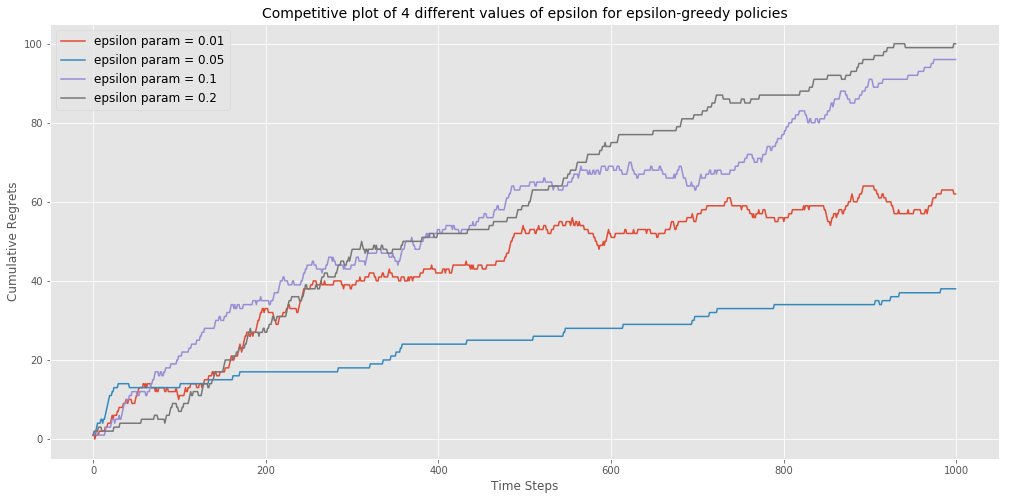

In [73]:
# Part 2 code, output your plot
# np.random.seed(5)
# run four policies 
num_arms = SimpleBandit().num_arms
eg_1 = Epsilon_Greedy_Policy(num_arms, 0.01)
eg_2 = Epsilon_Greedy_Policy(num_arms, 0.05)
eg_3 = Epsilon_Greedy_Policy(num_arms, 0.1)
eg_4 = Epsilon_Greedy_Policy(num_arms, 0.2)
policies = [eg_1, eg_2, eg_3, eg_4]
regrets_history_epsi = {}
for tmp_policy in policies:
    CurRewardList = []
    regrets_history_epsi[tmp_policy] = modified_run_trajectory(SimpleBandit(), [tmp_policy], 1000)
    print(regrets_history_epsi[tmp_policy][-1])
    
# plot 
plt.figure(figsize=(17, 8))
plt.plot(range(1000), regrets_history_epsi[eg_1], '-', label='epsilon param = 0.01', color=colors[0])
plt.plot(range(1000), regrets_history_epsi[eg_2], '-', label='epsilon param = 0.05', color=colors[1])
plt.plot(range(1000), regrets_history_epsi[eg_3], '-', label='epsilon param = 0.1', color=colors[2])
plt.plot(range(1000), regrets_history_epsi[eg_4], '-', label='epsilon param = 0.2', color=colors[3])
plt.legend(fontsize=12)
plt.xlabel('Time Steps', fontsize=12)
plt.ylabel('Cumulative Regrets', fontsize=12)
plt.title("Competitive plot of 4 different values of epsilon for epsilon-greedy policies", fontsize=14)

### Findings and conclusion for part 2

## Part 5.3

Try 4 different values of  𝐶  in UCB: 0.5, 0.75, 1, 2 and have them compete. Plot the regrets as a function of t. Note the best performing selection of 𝐶 at 𝑇=1000.

[48.0]
[99.0]
[143.0]
[155.0]


Text(0.5, 1.0, 'Competitive plot of 4 different values of C for UCB policies')

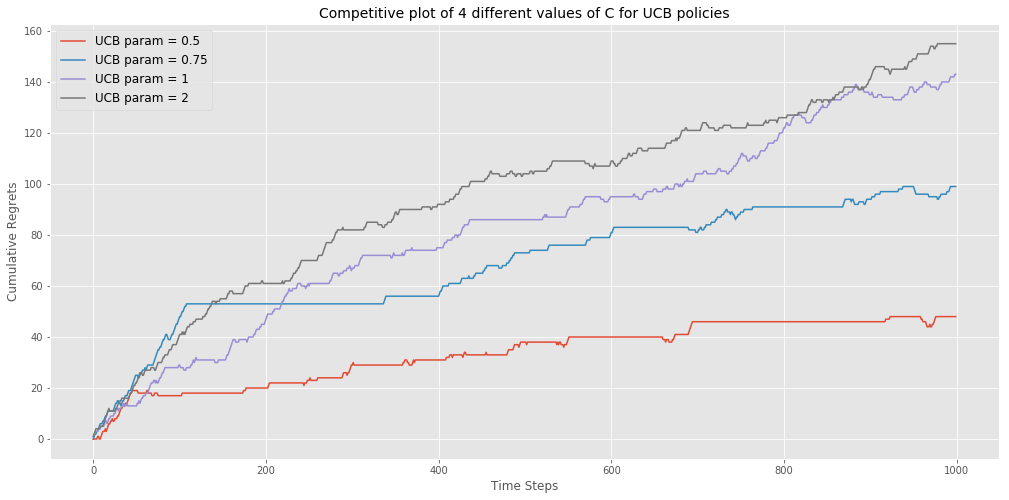

In [70]:
# Part 3 code, output your plot
# np.random.seed(5)
# run four policies 
num_arms = SimpleBandit().num_arms
ucb_1 = UCB(num_arms, 0.5)
ucb_2 = UCB(num_arms, 0.75)
ucb_3 = UCB(num_arms, 1)
ucb_4 = UCB(num_arms, 2)
policies = [ucb_1, ucb_2, ucb_3, ucb_4]
regrets_history_ucb = {}
for tmp_policy in policies:
    CurRewardList = []
    regrets_history_ucb[tmp_policy] = modified_run_trajectory(SimpleBandit(), [tmp_policy], 1000)
    print(regrets_history_ucb[tmp_policy][-1])
    
# plot 
plt.figure(figsize=(17, 8))
plt.plot(range(1000), regrets_history_ucb[ucb_1], '-', label='UCB param = 0.5', color=colors[0])
plt.plot(range(1000), regrets_history_ucb[ucb_2], '-', label='UCB param = 0.75', color=colors[1])
plt.plot(range(1000), regrets_history_ucb[ucb_3], '-', label='UCB param = 1', color=colors[2])
plt.plot(range(1000), regrets_history_ucb[ucb_4], '-', label='UCB param = 2', color=colors[3])
plt.legend(fontsize=12)
plt.xlabel('Time Steps', fontsize=12)
plt.ylabel('Cumulative Regrets', fontsize=12)
plt.title("Competitive plot of 4 different values of C for UCB policies", fontsize=14)

### Findings and conclusion for part 3

## Part 5.4

Using the optimal values of  𝐶  and  𝜖  have all four methods compete. Plot the regrets as a function of t, remark on if the relative performance changes over time. Is one algorithm always dominant? Make any other conclusions.

[381.0]
[161.0]
[132.0]
[79.0]


Text(0.5, 1.0, 'Competitive plot of 4 different policies')

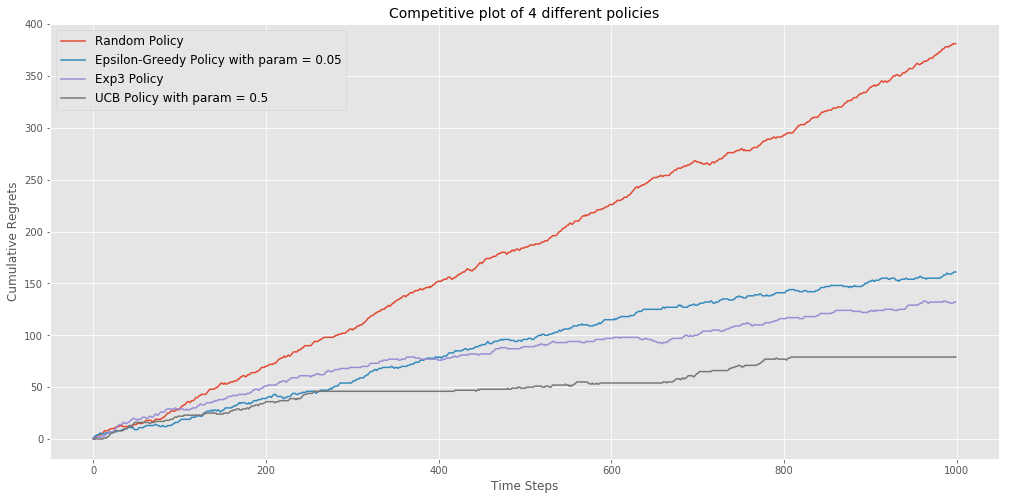

In [78]:
# Part 4 code, output your plot
# np.random.seed(5)
# select cases of Epsilon-Greedy and UCB policies from previous experiements with the best performance？ 
# run four policies 
num_arms = SimpleBandit().num_arms
rp = RandomPolicy(num_arms)
eg_2 = Epsilon_Greedy_Policy(num_arms, 0.05)
exp3 = Exp3(num_arms)
ucb_1 = UCB(num_arms, 0.5)
policies = [rp, eg_2, exp3, ucb_1]

regrets_history_mix = {}
for tmp_policy in policies:
    CurRewardList = []
    regrets_history[tmp_policy] = modified_run_trajectory(SimpleBandit(), [tmp_policy], 1000)
    print(regrets_history[tmp_policy][-1])
    
# plot 
plt.figure(figsize=(17, 8))
plt.plot(range(1000), regrets_history[rp], '-', label='Random Policy', color=colors[0])
plt.plot(range(1000), regrets_history[eg_2], '-', label='Epsilon-Greedy Policy with param = 0.05', 
         color=colors[1])
plt.plot(range(1000), regrets_history[exp3], '-', label='Exp3 Policy', color=colors[2])
plt.plot(range(1000), regrets_history[ucb_1], '-', label='UCB Policy with param = 0.5', color=colors[3])
plt.legend(fontsize=12)
plt.xlabel('Time Steps', fontsize=12)
plt.ylabel('Cumulative Regrets', fontsize=12)
plt.title("Competitive plot of 4 different policies", fontsize=14)

### Findings and conclusion for part 4